# Advanced Lane Finding Project
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---

## Import all the required libraries

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Polygon
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

### Step 1: Compute the camera calibration using chessboard images

In [2]:
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

def calibrate_camera(images):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        else:
            ret, mtx, dist, rvecs, tvecs = None, None, None, None, None
            
    return ret, mtx, dist, rvecs, tvecs

ret, mtx, dist, rvecs, tvecs = calibrate_camera(images)

### Step 2: Apply a distortion correction to the raw images

In [3]:
def distortion_correction(img, mtx, dist):
    # Apply the distortion correction to the raw image
    dst = cv2. undistort(img, mtx, dist, None, mtx)
    return dst

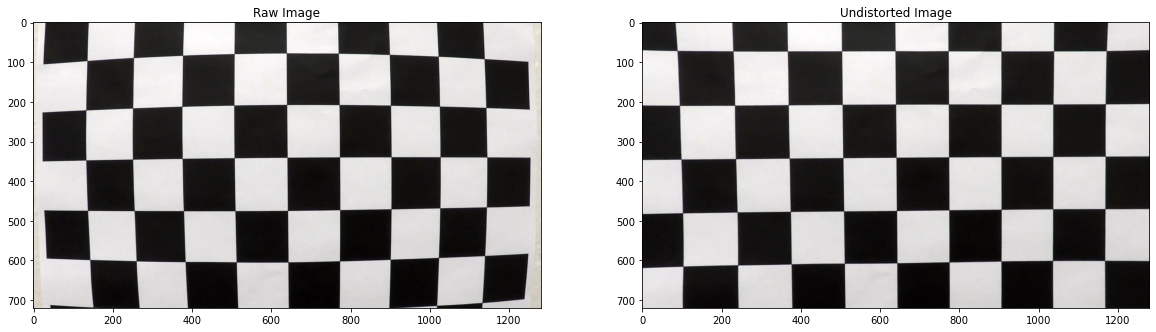

In [4]:
# Undistort a test image
img = mpimg.imread('./camera_cal/calibration1.jpg')
undistorted_img = distortion_correction(img, mtx, dist)

# Visualize undirstorsion
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 8))
ax1.set_title("Raw Image", fontsize = 12)
ax1.imshow(img)
ax2.set_title("Undistorted Image", fontsize = 12)
ax2.imshow(undistorted_img, cmap = 'gray')

### Step 3: Use color transforms, gradients, etc., to create a thresholded binary image

In [5]:
# Define a function that applies Sobel x or y, then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', sobel_kernel = 3, thresh = (0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return the binary image
    return binary_output

# Define a function to return the magnitude of the gradient for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel = 3, thresh = (0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag) / 255 
    gradmag = (gradmag / scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    # Return the binary image
    return binary_output

# Define a function that applies Sobel x and y, then computes the direction of the gradient and applies a threshold
def dir_thresh(img, sobel_kernel = 3, thresh = (0, np.pi/2)): 
    # Apply the following steps to img
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    dir_sobel = np.arctan2(abs_sobely, abs_sobelx)
    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(dir_sobel)
    binary_output[(dir_sobel >= thresh[0]) & (dir_sobel <= thresh[1])] = 1
    # Return this mask as your binary_output image
    return binary_output

# Define a function that applies color threshold using HLS
def color_thresh(img, thresh=(170, 255)):
    # HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Select S channel because it is usually the best performant for this task. R channel also performs similarly.
    s_channel = hls[:,:,2] 
    
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def combined_thresh(gradx, grady, mag_binary, dir_binary, color_binary, ksize = 3):
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (color_binary == 1)] = 1
    return combined

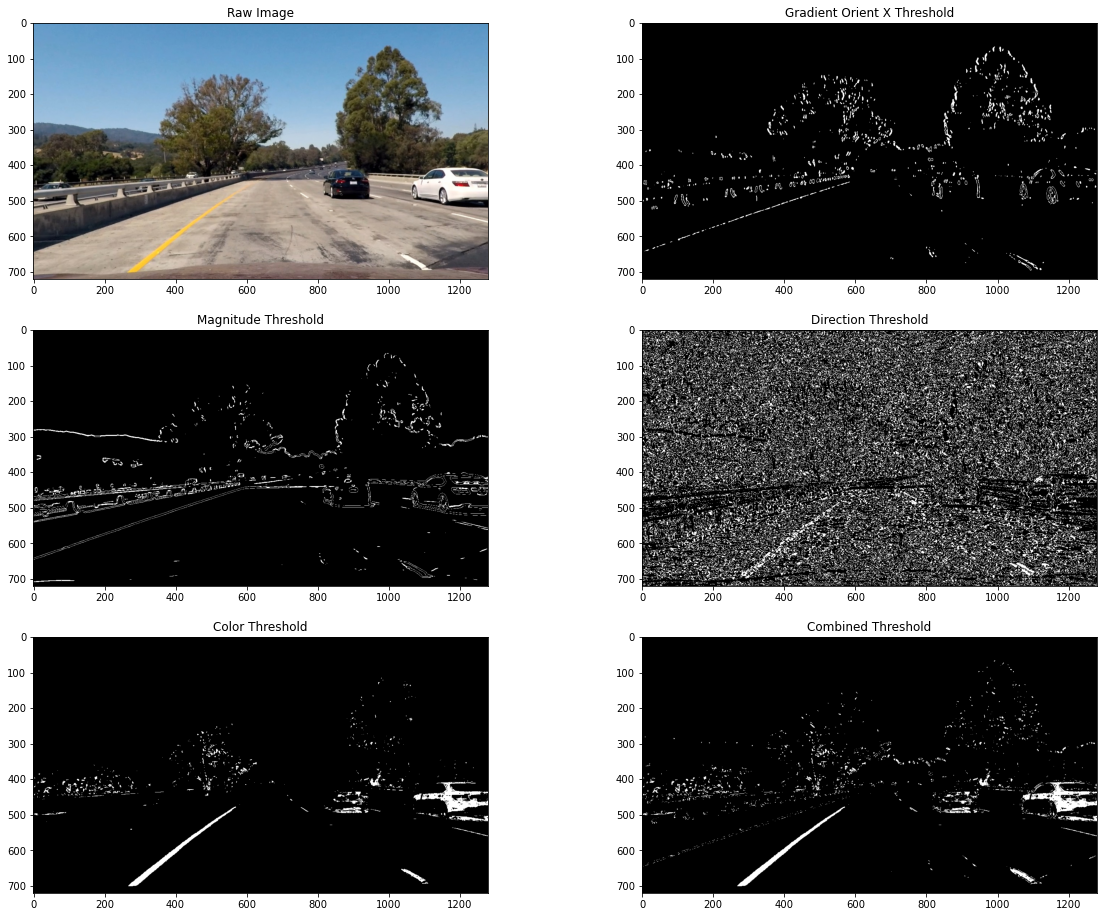

In [13]:
# Load a test image, convert to RGB and undistort it
img = mpimg.imread('./test_images/test1.jpg')
img = distortion_correction(img, mtx, dist)

# Run the function
gradx = abs_sobel_thresh(img, orient='x', sobel_kernel = 15, thresh = (50, 100))
grady = abs_sobel_thresh(img, orient='y', sobel_kernel = 15, thresh = (50, 100))
mag_binary = mag_thresh(img, sobel_kernel = 15, thresh = (70, 100))
dir_binary = dir_thresh(img, sobel_kernel = 9, thresh = (0.8, 1.2))
color_binary = color_thresh(img, thresh = (170, 255))
combined_binary = combined_thresh(gradx, grady, mag_binary, dir_binary, color_binary)

# Visualization
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize = (20, 16))
ax1.set_title("Raw Image", fontsize = 12)
ax1.imshow(img)
ax2.set_title("Gradient Orient X Threshold", fontsize = 12)
ax2.imshow(gradx, cmap = 'gray')
ax3.set_title("Magnitude Threshold", fontsize = 12)
ax3.imshow(mag_binary, cmap = 'gray')
ax4.set_title("Direction Threshold", fontsize = 12)
ax4.imshow(dir_binary, cmap = 'gray')
ax5.set_title("Color Threshold", fontsize = 12)
ax5.imshow(color_binary, cmap = 'gray')
ax6.set_title("Combined Threshold", fontsize = 12)
ax6.imshow(combined_binary, cmap = 'gray')

### Step 4: Apply a perspective transform to rectify binary image ("birds-eye view")

In [38]:
# Define perspective transform function
def warp(img):
    # Define calibration box in source (original) and destination (desired or warped) coordinates
    img_size = (img.shape[1], img.shape[0])
    # img = distortion_correction(img)
        
    src = np.float32(
            [[270,  690],  # Bottom left
             [535,  490],  # Top left
             [785,  490],  # Top right
             [1125, 690]]) # Bottom right

    dst = np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1050,   0],  # Top right
             [1050, 720]]) # Bottom right   

    # Compute the perspective transfor, M
    M = cv2.getPerspectiveTransform(src, dst)

    # Compute the inverse perspective transfor also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Create warped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)

    return warped, M, Minv

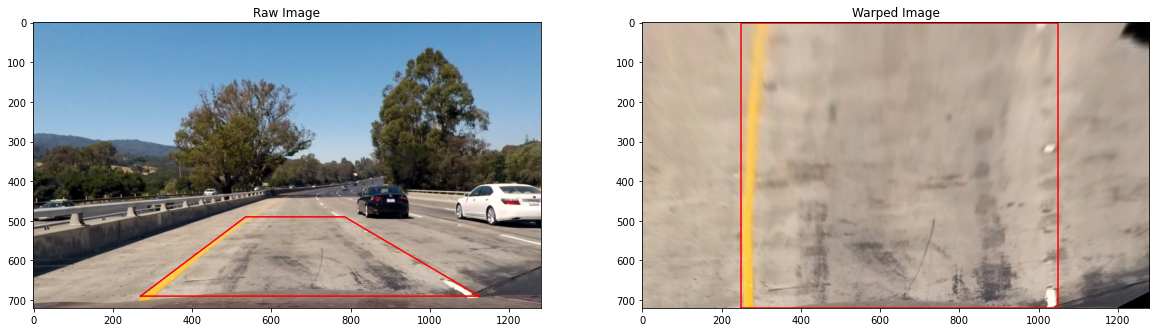

In [39]:
warped_img, M, Minv = warp(img)

src = np.float32(
    [[270,  690],  # Bottom left
     [535,  490],  # Top left
     [785,  490],  # Top right
     [1125, 690]]) # Bottom right

dst = np.float32(
    [[250,  720],  # Bottom left
     [250,    0],  # Top left
     [1050,   0],  # Top right
     [1050, 720]]) # Bottom right  

# Visualize warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 8))
ax1.set_title("Raw Image", fontsize = 12)
ax1.plot(Polygon(src).get_xy()[:, 0], Polygon(src).get_xy()[:, 1], color='red')
ax1.imshow(img)
ax2.set_title("Warped Image", fontsize = 12)
ax2.plot(Polygon(dst).get_xy()[:, 0], Polygon(dst).get_xy()[:, 1], color='red')
ax2.imshow(warped_img)

### Step 5: Detect lane pixels and fit to find the lane boundary

In [40]:
def get_hist(img):
    # Normalize back to 0-1
    img = img / 255
    return np.sum(img[img.shape[0]//2:, :], axis = 0)

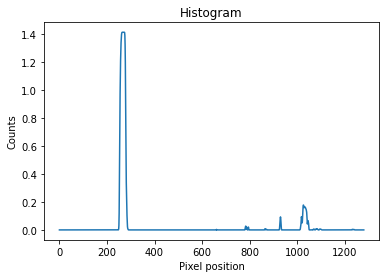

In [41]:
# Run histogram function over the combined warped image
combined_warped, M, Minv = warp(combined_binary)
hist = get_hist(combined_warped)

# Visulization
plt.title('Histogram', fontsize = 12)
plt.xlabel('Pixel position')
plt.ylabel('Counts')
plt.plot(hist)

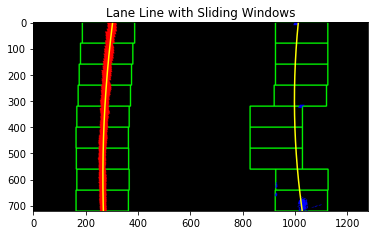

In [42]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = get_hist(binary_warped)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        
        # Find the four below boundaries of the window 
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0,255,0), 3) 
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0,255,0), 3) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high) & 
                          (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox < win_xright_high) & 
                           (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window (`right` or `leftx_current`) on their mean position 
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1 * ploty**2 + 1 * ploty
        right_fitx = 1 * ploty**2 + 1 * ploty

    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img.astype('uint8'), left_fit, right_fit

out_img = fit_polynomial(combined_warped)[0]
plt.title('Lane Line with Sliding Windows', fontsize = 12)
plt.imshow(out_img)

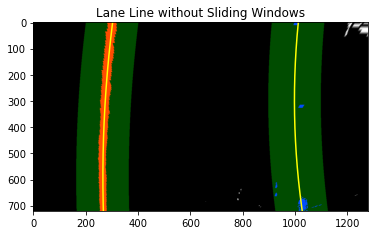

In [43]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calculate both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2] 
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # Choose the width of the margin around the previous polynomial to search
    margin = 100
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values within the +/- margin of our polynomial function
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result.astype('uint8'), left_fitx, right_fitx, ploty

# Retrive the lane lines from the image
out_img, left_fit, right_fit = fit_polynomial(combined_warped)
result, left_fitx, right_fitx, ploty = search_around_poly(combined_warped, left_fit, right_fit)
plt.title('Lane Line without Sliding Windows', fontsize = 12)
plt.imshow(result)

### Step 6: Determine the curvature of the lane and vehicle position with respect to center

In [44]:
def measure_curvature_pixels(combined_warped, left_fit, right_fit):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720 # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700 # meters per pixel in x dimension

    # Make sure to feed in your real data instead in your project!
    result, leftx, rightx, ploty = search_around_poly(combined_warped, left_fit, right_fit)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, rightx * xm_per_pix, 2)

    # Implement the calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / (np.absolute(2 * left_fit_cr[0]))
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / (np.absolute(2 * right_fit_cr[0])) 
    
    return left_curverad, right_curverad

# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels(combined_warped, left_fit, right_fit)
print('Left line curvature:', left_curverad, 'm')
print('Right line curvature:', right_curverad, 'm')

Left line curvature: 1546.080036221304 m
Right line curvature: 1072.1365237662583 m


### Step 7: Warp the detected lane boundaries back onto the original image

In [45]:
def draw_lane(img, warped_img, left_fitx, right_fitx, ploty, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

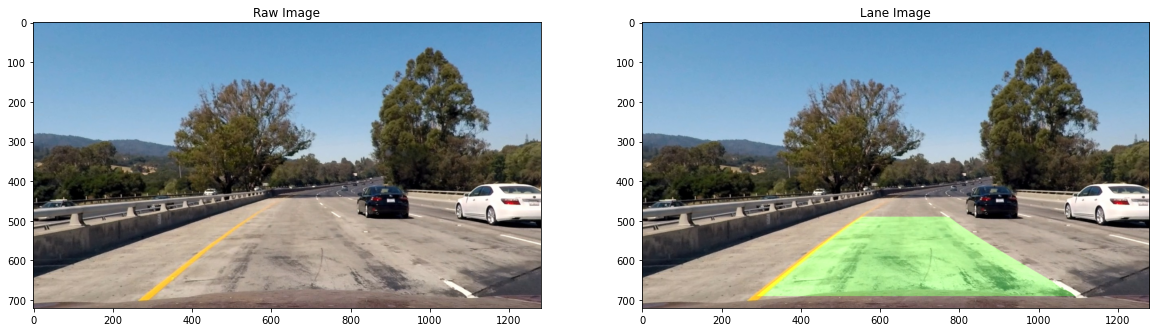

In [46]:
# Run the function
lane_img = draw_lane(img, combined_warped, left_fitx, right_fitx, ploty, Minv)

# Visualize warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 8))
ax1.set_title("Raw Image", fontsize = 12)
ax1.imshow(img)
ax2.set_title("Lane Image", fontsize = 12)
ax2.imshow(lane_img)

### Step 8: Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

In [47]:
def overlay_information(img, left_curverad, right_curverad, leftx, rightx):    
    # Calculate car offset
    ym_per_pix = 30 / 720 # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700 # meters per pixel in x dimension
        
    # Image mid horizontal position 
    midpoint_x = img.shape[1]//2

    # Car position with respect to the lane
    car_pos = (leftx[-1] + rightx[-1])/2
    
    ## Horizontal car offset 
    offset_x = (midpoint_x - car_pos) * xm_per_pix  

    out_img = img.copy()
    # Display lane curvature
    cv2.putText(out_img, 'Left lane line curvature: {:.2f} m'.format(left_curverad), 
                (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    cv2.putText(out_img, 'Right lane line curvature: {:.2f} m'.format(right_curverad), 
                (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    # Display car offset
    cv2.putText(out_img, 'Horizontal car offset from the center: {:.2f} m'.format(offset_x), 
               (20, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        
    return out_img

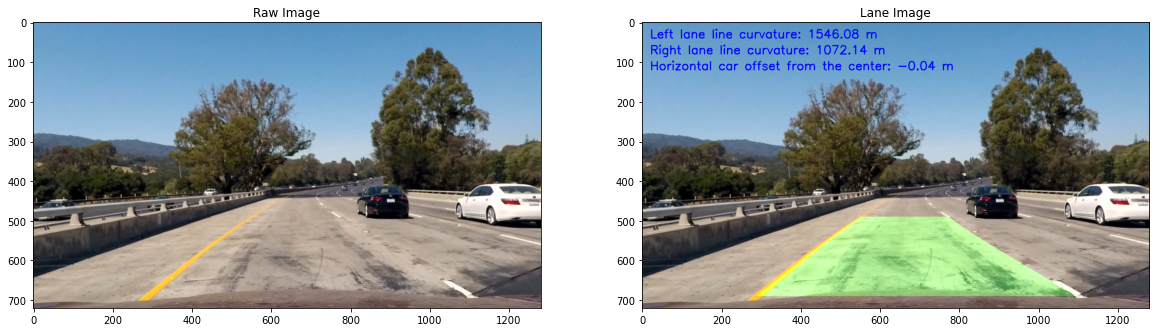

In [48]:
overlay_img = overlay_information(lane_img, left_curverad, right_curverad, left_fitx, right_fitx)

# Visualize warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 8))
ax1.set_title("Raw Image", fontsize = 12)
ax1.imshow(img)
ax2.set_title("Lane Image", fontsize = 12)
ax2.imshow(overlay_img)

### Step 9: Run pipeline in a video.

In [49]:
class ProcessImage:
    
    def __init__(self, images):
        # Make a list of calibration images
        images = glob.glob(images)

        # Calibrate camera
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = calibrate_camera(images)

    def __call__(self, img):

        # Undistord image
        img = distortion_correction(img, self.mtx, self.dist)

        # Calculate directional gradient
        gradx = abs_sobel_thresh(img, orient='x', sobel_kernel = 15, thresh = (30, 100))
        grady = abs_sobel_thresh(img, orient='y', sobel_kernel = 15, thresh = (30, 100))

        # Calculate gradient magnitude 
        mag_binary = mag_thresh(img, sobel_kernel = 15, thresh = (70, 100))

        # Calculate gradient direction
        dir_binary = dir_thresh(img, sobel_kernel = 15, thresh = (0.7, 1.3))

        # Calculate color threshold
        col_binary = color_thresh(img, thresh = (170, 255))

        # Combine all the thresholds to identify the lane lines
        combined_binary = combined_thresh(gradx, grady, mag_binary, dir_binary, color_binary)

        # Apply a perspective transform to rectify binary image ("birds-eye view")
        combined_warped, M, Minv = warp(combined_binary)

        out_img, left_fit, right_fit = fit_polynomial(combined_warped)
        result, left_fitx, right_fitx, ploty = search_around_poly(combined_warped, left_fit, right_fit)

        # Warp the detected lane boundaries back onto the original image.
        lane_img = draw_lane(img, combined_warped, left_fitx, right_fitx, ploty, Minv)

        # Add metrics to the output img
        out_img = overlay_information(lane_img, left_curverad, right_curverad, left_fitx, right_fitx)

        return out_img

[MoviePy] >>>> Building video ./output_images/project_video_solution.mp4
[MoviePy] Writing video ./output_images/project_video_solution.mp4


 99%|███████████████████████████████████████████████████████████████████████████████▎| 125/126 [01:06<00:00,  1.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video_solution.mp4 

Wall time: 1min 7s


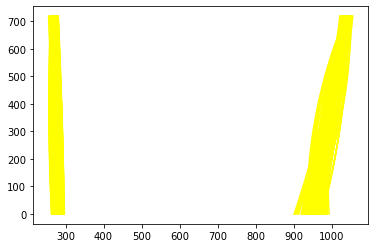

In [50]:
input_video = './project_video.mp4'
output_video = './output_images/project_video_solution.mp4'

# You may uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip(input_video).subclip(0,5)

process_image = ProcessImage('./camera_cal/calibration*.jpg')
white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video, audio = False)

In [51]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video))